# This is an explanantion how Finite Element Method works. Basically we are going to see the Rayleigh-Ritz method, then the Residual method, the Galerking method and finally the Finite Element method.

## At first, we are going to solve the following equation:

\begin{eqnarray}
-\frac{d^2u}{dx^2}+u=6-3x^2+20x-3\sin\left(\frac{3{\pi}x}{2}\right)-\frac{27{\pi}^2}{4}\sin\left(\frac{3{\pi} x}{2}\right).
\label{eq-dif}
\end{eqnarray}

## that can be re-written as,

\begin{eqnarray}
Lu=h, \nonumber
\end{eqnarray} 	

## where,		
\begin{eqnarray}
L=-\frac{d^2}{dx^2}+1 \nonumber
\end{eqnarray} 
	
## and,	
\begin{eqnarray}
h=6-3x^2+20x-3\sin\left(\frac{3{\pi}x}{2}\right)-\frac{27{\pi}^2}{4}\sin\left(\frac{3{\pi} x}{2}\right). \nonumber
\end{eqnarray}

## $L$ is a linear operator that can define a dot product. (I need to remember better how to go from (1) to (2), but with the other methods that is clear.) 

\begin{eqnarray}
<Lu,\phi>\hspace{0.2cm}=\hspace{0.2cm}<u,\phi>_L, \; \; \; \; \; \; \; \; \; \; \; \;  (1)
\end{eqnarray}
	 	
## defined as,
	 	
\begin{eqnarray}
<u,\phi>_L\hspace{0.2cm}= \int_0^1 [u'(x)\phi'(x)+u(x)\phi(x)]dx.  \; \; \; (2)
\end{eqnarray}	 	
	 	
## Basicaly we project both sides of the equation in the subspace driven by the base functions related to $L$
	
\begin{eqnarray}
<u,\phi>_L\hspace{0.2cm}=\hspace{0.2cm} <h,\phi>_L \nonumber
\end{eqnarray}

## or,

\begin{eqnarray}
\int_0^1 [u'(x)\phi'(x)+u(x)\phi(x)]dx=\int_0^1 [h(x)\phi(x)]dx. \nonumber
\end{eqnarray}	

## So, if we have $n$ base functions,

\begin{eqnarray}
\sum_{j=1}^{n} <\phi_i,\phi_j>_L \alpha_n= <\phi_i,h>_L
\end{eqnarray}

## The base functions can be any set of functions that define a subspace. Being zero at the borders are important in order to contain the trivial base function, zero everywhere.

\begin{eqnarray}
\phi_n = x^n(1-x),
\end{eqnarray}

## or,

\begin{eqnarray}
\psi_n = x^{\frac{n-1}{2}}\sin(\pi x),
\end{eqnarray}

## Defining the $u$ function as a linear combination of the base functions ($\phi$ or $\psi$),
	
\begin{eqnarray}
u = \alpha_1\phi_1+\alpha_2\phi_2....+\alpha_n\phi_n+...
\label{CL}
\end{eqnarray}  	

## we have a linear system,

\begin{eqnarray}
\sum_{j=1}^n\alpha_j\int_0^1 [\phi_j'(x)\phi_i'(x)+\phi_j(x)\phi_i(x)]dx = \int_0^1 [\phi_i(x)h(x)]dx, \; i=1,2...n, \nonumber
\end{eqnarray}

## The hole idea is that the integrals are easier to be solved now in terms of the base functions. By increasig the number of bases we reduce the error. Now, let's solve this differencial equation.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import sympy
from scipy.integrate import quad
import scipy.sparse.linalg as ll


In [50]:
m = np.int(input("Please, how many bases you need?\n"))

Please, how many bases you need?
5


### Defining some functions

In [51]:
def csch(x):
    return sympy.sinh(x)**(-1)

def h(x):
    return 6 - 3*x**2 + 20*x - 3*np.sin(3*np.pi*x/2) - (27*np.pi**2)*np.sin(3*np.pi*x/2)/4

# analytical solution
def ua(x):
    return -3* x**2 + 20*x - 3*np.sin(3*np.pi*x/2) - 20*csch(1)*np.sinh(x)

# bases of type one (phi)
def phi(x, n):
    return x**n*(1-x)

# derivative of bases of type one (phi)
def dphi(x, n):
    return n*( x**(n -1)) - (( n +1)*x**n)

# bases of type two (psi)
def psi(x, n):
    return x**((n - 1)/2)*np.sin(np.pi*x)

# derivative of bases of type two (psi)
def dpsi(x, n):
    return ((n - 1)/2)*(x**((n - 3)/2))*np.sin (np.pi*x) + np.pi*(x**((n - 1)/2))*np.cos(np.pi*x)

# bases of type three (hat)
def hat(x, n):
    y = x*0
    for i, v in enumerate(x):
        if(x[i] < pp[n-1] or x[i] > pp[n+1]):
            y[i] = 0
        elif(pp[n-1] <= x[i] and x[i] <= pp[n]):
            y[i] = (x[i] - pp[n-1]) / (pp[n] - pp[n-1])
        else:#elif(pp[n] <= x[i] and x[i] <= pp[n+1]):
            y[i] = (pp[n+1] - x[i]) / (pp[n+1] - pp[n])
    return y

# Analitical solution for the terms of the main diagonal when using the hat function
def hatd(x, n):
    return 1/(x[n] - x[n-1]) + 1/(x[n+1] - x[n]) + (x[n] - x[n-1])/3 + (x[n+1] - x[n])/3

# Analitical solution for the terms of the side diagonals when using the hat function
def hatd2(x, n):
    return -1/(x[n+1] - x[n]) + (x[n+1] - x[n])/6

def fem1(x, n):
    return 1 - (x - pp[n-1])/(pp[n] - pp[n-1])

def fem2(x, n):
    return (x - pp[n-1])/(pp[n] - pp[n-1])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

# In case you wanna to solve the system by using the method of elimination (it takes forever)
def A2U(A:complex):        
    n = len(A)
    U = A.copy()
    vm = np.zeros(int(n*(n-1)/2), dtype=complex)
    count = 0   
    for j in range(n):
        
        for i in range(j+1, n):
            vm[count] = U[i,j] / U[j,j]            
            for k in range(n):               
                U[i,k] += -vm[count]*U[j,k]                
            count += 1
       
    return U, vm

def y2g(y:complex, vm:complex):
    n = len(y)
    g = y.copy()
    count = 0
    
    for k in range(n):        
        for j in range(k+1, n):
            g[j] +=  -vm[count]*g[k]
            count += 1
    return g

def sol_Gauss(U:complex, g:complex):
    
    n = len(U) - 1
    x = np.zeros(len(g))

    for k in range(n, -1, -1):
        s = 0
        for j in range(n, k,-1):
               
            s += U[k,j]*x[j]
    
        x[k] = (g[k] - s) / U[k, k]
        
    return x


# Rayleigh-Ritz
## $\phi$ 

In [52]:
A = np.zeros([m,m])
b = np.zeros(m)

In [53]:
for p in range(m):
    b[p], err = quad(lambda x,p: phi(x,p+1)*h(x), 0, 1, args=(p,))
    for q in range(m):
        A[p, q] = quad(lambda x,p,q: phi(x, p+1)*phi(x, q+1), 0, 1, args=(p,q))[0] + quad(lambda x,p,q: dphi(x, p+1)*dphi(x, q+1), 0, 1, args=(p,q))[0]

In [54]:
coef1 = np.matmul(b, np.linalg.pinv(A))

In [55]:
x = np.linspace(0,1,1000)

In [56]:
colors = ['r', 'm', 'g', 'c', 'b', 'm', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']

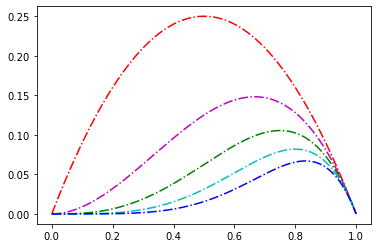

In [57]:
u1 = np.zeros(len(x))
xx = np.linspace(0,1,5)
u2 = np.zeros(len(xx))
for p in range(m):
    u1 = u1 + coef1[p]*phi(x, p+1)
    u2 = u2 + coef1[p]*phi(xx, p+1)
    plt.plot(x, phi(x,p+1), '-.' + colors[p])

### above are the base functions of type $\phi$ and below are the coefitients ($\alpha_{j}$) we found in order to obtain the solution by linear combinantion of the basis.

In [58]:
coef1

array([-11.04753674, -16.09089956,  44.87007842,  20.33940245,
       -25.96786498])

(-5.0, 5.0)

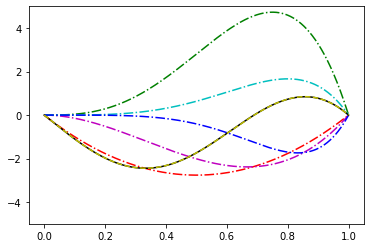

In [59]:
for p in range(m):
    plt.plot(x, coef1[p]*phi(x,p+1), '-.' + colors[p])
plt.plot(x, ua(x), 'k', x, u1, '--y')
#plt.plot(xx, u2, '*r')

plt.ylim([-5, 5])

### above are the solution (analytical and numerical) and the base functions multiplied by the corresponding coeficient. We can see how each one contribute to the solution.

# Rayleigh-Ritz
## $\psi$

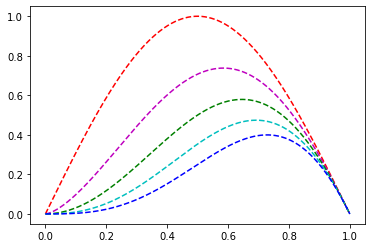

In [60]:
B = np.zeros([m,m])
d = np.zeros(m)

for p in range(m):
    d[p], err = quad(lambda x,p: psi(x,p+1)*h(x), 0, 1, args=(p,))
    for q in range(m):
        B[p, q] = quad(lambda x,p,q: psi(x, p+1)*psi(x, q+1), 0, 1, args=(p,q))[0] + quad(lambda x,p,q: dpsi(x, p+1)*dpsi(x, q+1), 0, 1, args=(p,q))[0]
    
coef_psi = np.matmul(d, np.linalg.pinv(B))
#x = np.linspace(0,1,1000)    
u_psi = np.zeros(len(x))
for p in range(m):
    u_psi = u_psi + coef_psi[p]*psi(x, p+1)
    plt.plot(x, psi(x,p+1), '--' + colors[p])

In [61]:
coef_psi

array([-3.63467067,  1.13303771, -6.06806228,  9.77583903,  2.69028304])

(-5.0, 5.0)

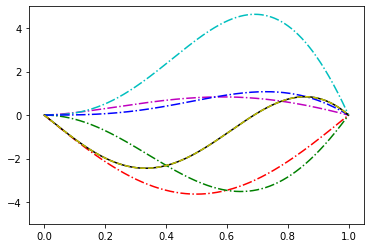

In [62]:
for p in range(m):
    plt.plot(x, coef_psi[p]*psi(x,p+1), '-.' + colors[p])
plt.plot(x, ua(x), 'k', x, u_psi, '--y')
plt.ylim([-5, 5])

# Residuos

## Basically is used a weight function ($v$) to minimize the error,

\begin{eqnarray}
-\frac{d^2u}{dx^2}+u-h =\epsilon, \nonumber
\end{eqnarray}

## Making $<\epsilon,v_i>=0$, we force the error to be orthogonal to each weigh function and then not belong to the same subspace of $v$ functions. As long as the number of functions increase $\epsilon \rightarrow 0$ is the only way to satisfy the dot product being zero.

\begin{eqnarray}
\int_0^1(-\frac{d^2u}{dx^2}+u-h)\ v=0, \nonumber
\end{eqnarray}

## Spliting the terms and by doing integration by parts twice, we have:

\begin{eqnarray}
\int_0^1 (u'v'+u\ v)dx + u v'\vert_{0}^{1}= \int_0^1 (v\ h)dx. \nonumber
\end{eqnarray}

### Because u is zero at the boundaries
\begin{eqnarray}
\int_0^1 (u'v'+u\ v)dx = \int_0^1 (v\ h)dx. \nonumber
\end{eqnarray}


## As we saw before,
\begin{eqnarray}
u = \alpha_1\phi_1+\alpha_2\phi_2....+\alpha_n\phi_n+...
\end{eqnarray}

## but $v$ can also be defined as a linear combination of base functions as well
\begin{eqnarray}
v = \beta_1\psi_1+\beta_2\psi_2....+\beta_n\psi_n+...
\end{eqnarray}

### and by making $\beta_i=1$, then, $v=\psi_1+\psi_2+...\psi_n...$ and truncating the sequence,

\begin{eqnarray}
\sum_{j=1}^n\alpha_j\int_0^1 [\phi_j'(x)\psi_i'(x)+\phi_j(x)\psi_i(x)]dx = \int_0^1 [h(x)\psi_i(x)]dx,
\ \ i=1,2...n, \nonumber
\end{eqnarray}

## Basically it is almost the same equation as before.

## $\phi$ as base functions and $\psi$ as weight functions to minimize the $\epsilon$

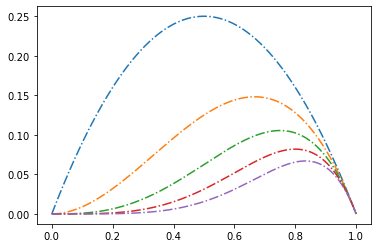

In [63]:
C = np.zeros([m,m])
d = np.zeros(m)

for p in range(m):
    d[p], err = quad(lambda x,p: psi(x,p+1)*h(x), 0, 1, args=(p,))
    for q in range(m):
        C[p, q] = quad(lambda x,p,q: phi(x, p+1)*psi(x, q+1), 0, 1, args=(p,q))[0] + quad(lambda x,p,q: dphi(x, p+1)*dpsi(x, q+1), 0, 1, args=(p,q))[0]
    
coef_residuos = np.matmul(d, np.linalg.pinv(C))
#x = np.linspace(0,1,1000)    
u_residuos = np.zeros(len(x))
for p in range(m):
    u_residuos = u_residuos + coef_residuos[p]*phi(x, p+1)
    plt.plot(x, phi(x,p+1), '-.')

In [64]:
coef_residuos

array([-11.12692401, -14.91928255,  39.94384241,  28.06580995,
       -29.98726421])

(-5.0, 5.0)

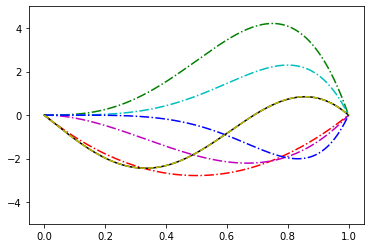

In [65]:
for p in range(m):
    plt.plot(x, coef_residuos[p]*phi(x,p+1), '-.' + colors[p])
plt.plot(x, ua(x), 'k', x, u_residuos, '--y')
plt.ylim([-5, 5])

### above are the solution (analytical and numerical) and the base functions ($\phi_j$) multiplied by the corresponding coeficient. We can see how each one contribute to the solution.

# Residuos
# $\psi$ as base functions and $\phi$ as weight functions to minimize the $\epsilon$


In [66]:
range(1,3,m)

range(1, 3, 5)

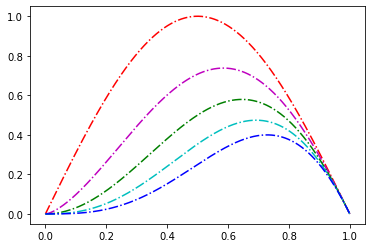

In [67]:
C = np.zeros([m,m])
d = np.zeros(m)

for p in range(m):
    d[p], err = quad(lambda x,p: phi(x,p+1)*h(x), 0, 1, args=(p,))
    for q in range(m):
        C[p, q] = quad(lambda x,p,q: psi(x, p+1)*phi(x, q+1), 0, 1, args=(p,q))[0] + quad(lambda x,p,q: dpsi(x, p+1)*dphi(x, q+1), 0, 1, args=(p,q))[0]
    
coef_residuos = np.matmul(d, np.linalg.pinv(C))
#x = np.linspace(0,1,1000)    
u_residuos = np.zeros(len(x))
for p in range(m):
    u_residuos = u_residuos + coef_residuos[p]*psi(x, p+1)
    plt.plot(x, psi(x,p+1), '-.' + colors[p])

In [68]:
coef_residuos

array([-3.68298096,  1.51934862, -7.13032552, 10.99163633,  2.19480849])

(-5.0, 5.0)

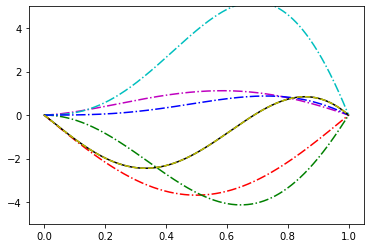

In [69]:
for p in range(m):
    plt.plot(x, coef_residuos[p]*psi(x,p+1), '-.' + colors[p])
plt.plot(x, ua(x), 'k', x, u_residuos, '--y')
plt.ylim([-5, 5])

### above are the solution (analytical and numerical) and the base functions ($\psi_j$) multiplied by the corresponding coeficient. We can see how each one contribute to the solution.

# Galerkin

# Galerkin is basically the residuos when the base functions are the same type as the weight functions

## But let's use the hat (^) functions this time. Otherwise the solution would be the same as obtained before with the Rayleigh-Ritz. (***There is a difference that makes the Galerkin more general, but I don't remember why)

## So, again we are going to solve,

\begin{eqnarray}
\sum_{j=1}^n\alpha_j\int_0^1 [\phi_j'(x)\phi_i'(x)+\phi_j(x)\phi_i(x)]dx = \int_0^1 [h(x)\phi_i(x)]dx,
\ \ i=1,2...n, \nonumber
\end{eqnarray}

## but 

\begin{eqnarray}
\phi(x)= 
\begin{cases}
    0,& \text{if } x\leq x_{i-1} \\
   (x - x_{i-1}) / (x_i − x_{i-1}) & \text{if } x_{i-1}\leq x \leq x_i      \\
   (x_{i+1} - x) / (x_{i+1} − x_i) & \text{if } x_{i}\leq x \leq x_{i+1}   \\
    0 & \text{if }             x\geq x_{i+1}
\end{cases}
\end{eqnarray}

## and
\begin{eqnarray}
\phi'(x)= 
\begin{cases}
    0,& \text{if } x\leq x_{i-1} \\
   1 / (x_i − x_{i-1}) & \text{if } x_{i-1}\leq x \leq x_i      \\
   -1 / (x_{i+1} − x_i) & \text{if } x_{i}\leq x \leq x_{i+1}   \\
    0 & \text{if }             x\geq x_{i+1}
\end{cases}
\end{eqnarray}

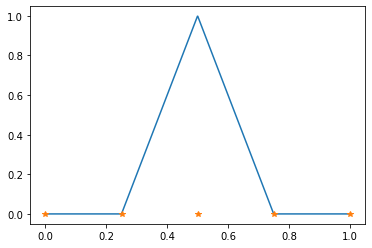

In [70]:
#pp = np.array([0, 1/6, 1/3, 1/2, 2/3, 3/4, 5/6, 11/12, 1])
#pp = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]) / 12
pp = np.linspace(0,1,m)

plt.plot(x, hat(x,2))
plt.plot(pp, pp*0, '*')

In [71]:
D = np.zeros([m,m])
g = np.zeros(m)

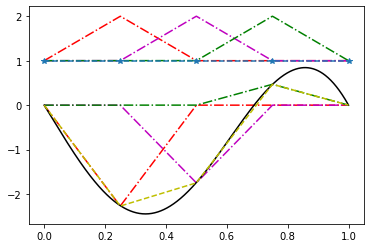

In [72]:
pp = np.linspace(0,1,m)

m = len(pp) - 2

for p in range(m):
    g[p] = quad(lambda x,p: (( x -  pp[p]) / (pp[p+1] - pp[p])) * h(x), pp[p], pp[p+1], args=(p,))[0] \
        + quad(lambda x,p: ((pp[p+2] - x) / (pp[p+2]-pp[p+1])) * h(x), pp[p+1], pp[p+2], args=(p,))[0] 
    for q in range(m):
        if( p == q ):
            D[p,q] = hatd(pp,p+1)
        elif(abs(p - q) == 1):
            D[p,q] = hatd2(pp,p+1)

coef_galerkin = np.matmul(g, np.linalg.pinv(D))

u_galerkin = np.zeros(len(x))

s=1 #shift
for p in range(m):
    u_galerkin = u_galerkin + coef_galerkin[p]*hat(x, p+1)
    plt.plot(x, hat(x,p+1) + s, '-.' + colors[p])
    plt.plot(x, coef_galerkin[p]*hat(x,p + s), '-.' + colors[p])

plt.plot(pp, pp*0+s, '--*')

plt.plot(x, ua(x), 'k', x, u_galerkin, '--y')


# irregular spacing (need to be fixed!)

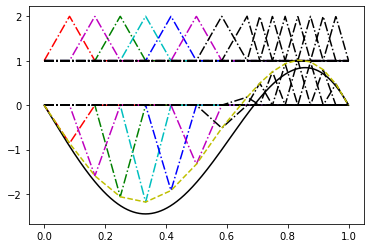

In [73]:
#pp = np.array([0, 1/6, 1/3, 1/2, 2/3, 3/4, 5/6, 11/12, 1])
pp = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]) / 12
#pp = np.linspace(0,1,m)

m = len(pp) - 2

D_ = np.zeros([m,m])
g_ = np.zeros(m)

for p in range(m):
    g_[p] = quad(lambda x,p:  (x - pp[p]) / (pp[p+1] - pp[p]) * h(x), pp[p], pp[p+1], args=(p,))[0] \
         + quad(lambda x,p: (pp[p+2] - x) / (pp[p+2] - pp[p+1]) * h(x), pp[p+1], pp[p+2], args=(p,))[0]
    
    for q in range(m):
        if( p == q ):
            D_[p,q] = hatd(pp,p+1)
        elif(abs(p - q) == 1):
            D_[p,q] = hatd2(pp,p+1)

coef_galerkin_ = np.matmul(g_, np.linalg.pinv(D_))

u_galerkin_ = np.zeros(len(x))

s=1 #shift
for p in range(m):
    u_galerkin_ = u_galerkin_ + coef_galerkin_[p]*hat(x, p+1)
    plt.plot(x, hat(x,p+1) + s, '-.' + colors[p])
    plt.plot(x, coef_galerkin_[p]*hat(x,p+1), '-.' + colors[p])

#plt.plot(pp, pp*0+s, '--*')

plt.plot(x, ua(x), 'k', x, u_galerkin_, '--y')


# Finite Element Method
## The FEM is based on the galerking method, but the main difference here is that while the base functions were defined in the entire domain, now we focus on a inner "element" or "cell" and define the simpliest base function inside it.

\begin{eqnarray}
\phi_1^e(\zeta) = 1 - \frac{\zeta - x_1^e}{x_2^e - x_1^e}
\end{eqnarray}

\begin{eqnarray}
\phi_2^e(\zeta) = \frac{\zeta - x_1^e}{x_2^e - x_1^e}
\end{eqnarray}

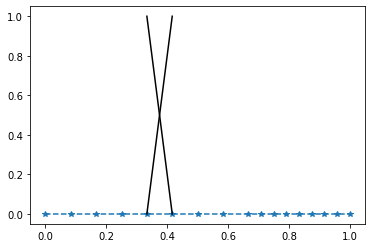

In [74]:
e = 5

#pp = np.array([0, 1/6, 1/3, 1/2, 2/3, 3/4, 5/6, 11/12, 1])
pp = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]) / 12
#pp = np.linspace(0,1,m)
m = len(pp)
plt.plot(pp, pp*0, '--*')

xx = np.linspace(pp[e-1], pp[e], 1000)
plt.plot(xx,fem1(xx,e),'k')
plt.plot(xx,fem2(xx,e),'k')

## and define $u$ as a linear combination of these two base functions (inside the interval),
	
\begin{eqnarray}
u(\zeta) = u_1^e\phi_1+u_2^e\phi_2
\end{eqnarray} 

\begin{eqnarray}
\sum_{j=1}^2[u_j(\int_{\Omega_e} [\phi_j'(x)\phi_i'(x)+\phi_j(x)\phi_i(x)]dx) + \phi_i \phi_j'\vert_{x^e_1}^{x^e_2}] = \int_{\Omega_e} h(x)\phi_i(x)dx,
\  \nonumber
\end{eqnarray}

## or
\begin{eqnarray}
\left[ \begin{array}{cc}
I^e & III^e \\
III^e & II^e \end{array} \right]
\left[ \begin{array}{c}
u^e_1 \\
u^e_2 \end{array} \right]
=\left[ \begin{array}{c}
IV^e \\
V^e \end{array} \right],
\label{sistema}
\end{eqnarray}

## where
\begin{eqnarray}
I^e=\int_{x^e_1}^{x^e_2} [\phi_1'(x)\phi_1'(x)+\phi_1(x)\phi_1(x)]dx, \nonumber
\end{eqnarray}

\begin{eqnarray}
II^e=\int_{x^e_1}^{x^e_2} [\phi_2'(x)\phi_2'(x)+\phi_2(x)\phi_2(x)]dx, \nonumber
\end{eqnarray}

\begin{eqnarray}
III^e=\int_{x^e_1}^{x^e_2} [\phi_2'(x)\phi_1'(x)+\phi_2(x)\phi_1(x)]dx, \nonumber
\end{eqnarray}

\begin{eqnarray}
IV^e=\left[\int_{x^e_1}^{x^e_2} [\phi_1(x)h(x)]dx\right]-u^e_1GI-u^e_2GIII_1
\label{f1}
\end{eqnarray}

\begin{eqnarray}
V^e=\left[\int_{x^e_1}^{x^e_2} [\phi_2(x)h(x)]dx\right]-u^e_1GIII_2-u^e_2GII, 
\label{f2} 
\end{eqnarray}
## and,
\begin{eqnarray}
GI=\phi_1 \phi_1'\vert_{x^e_1}^{x^e_2}
\label{GI}
\end{eqnarray}

\begin{eqnarray}
GII=\phi_2 \phi_2'\vert_{x^e_1}^{x^e_2}
\end{eqnarray}

\begin{eqnarray}
GIII_1=\phi_1 \phi_2'\vert_{x^e_1}^{x^e_2}\ or\ GIII_2=\phi_2 \phi_1'\vert_{x^e_1}^{x^e_2}
\end{eqnarray}

## Now, we 'pretend' we are going to solve the 2x2 linear system, but actually we solve this simple integrals and construct a global system:

\begin{eqnarray}
\left[ \begin{array}{ccccc}
I^1_{11} & III^1_{12}          & 0 & 0 & 0 \\
III^1_{21} & II^1_{22}+I^2_{11} & III^2_{12} & 0 & 0 \\
0        & III^2_{21}          & II^2_{22}+I^3_{11} & III^3_{12} & 0\\
0        & 0                 & III^3_{22} & II^3_{12}+I^4_{11} & III^4_{12}\\
0        & 0                 & 0 & III^4_{21}  & II^4_{22} \end{array} \right]
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\
u_4 \\
u_5 \end{array} \right]
=\left[ \begin{array}{c}
IV^1_{1} \\
V^1_{2}+IV^2_{1} \\
V^2_{2}+IV^3_{1}\\
V^3_{2}+IV^4_{1}\\
V^4_{2} \end{array} \right], \nonumber
\end{eqnarray}

($-u^e_1GI-u^e_2GIII_1$) and ($-u^e_1GIII_2-u^e_2GII$) are both zero for inner elements. 

## Boundary conditions (Dirichlet)
### Replace the first and last equation

\begin{eqnarray}
\left[ \begin{array}{ccccc}
1 & 0          & 0 & 0 & 0 \\
III^1_{21} & II^1_{22}+I^2_{11} & III^2_{12} & 0 & 0 \\
0        & III^2_{21}          & II^2_{22}+I^3_{11} & III^3_{12} & 0\\
0        & 0                 & III^3_{22} & II^3_{12}+I^4_{11} & III^4_{12}\\
0        & 0                 & 0 & 0  & 1 \end{array} \right]
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\
u_4 \\
u_5 \end{array} \right]
=\left[ \begin{array}{c}
u_{top} \\
V^1_{2}+IV^2_{1} \\
V^2_{2}+IV^3_{1}\\
V^3_{2}+IV^4_{1}\\
u_{bottom} \end{array} \right], \nonumber
\end{eqnarray} 

### or,
\begin{eqnarray}
\left[ \begin{array}{ccccc}
BIG & III^1_{12}          & 0 & 0 & 0 \\
III^1_{21} & II^1_{22}+I^2_{11} & III^2_{12} & 0 & 0 \\
0        & III^2_{21}          & II^2_{22}+I^3_{11} & III^3_{12} & 0\\
0        & 0                 & III^3_{22} & II^3_{12}+I^4_{11} & III^4_{12}\\
0        & 0                 & 0 & III^4_{21}  & BIG \end{array} \right]
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\
u_4 \\
u_5 \end{array} \right]
=\left[ \begin{array}{c}
u_{top}\times BIG \\
V^1_{2}+IV^2_{1} \\
V^2_{2}+IV^3_{1}\\
V^3_{2}+IV^4_{1}\\
u_{bottom}\times BIG \end{array} \right], \nonumber
\end{eqnarray} 

## By solving the global system, you already have the solution at the nodes (***You don't need to compute the linear combination because one of the two base functions will be zero at one of the two nodes) 

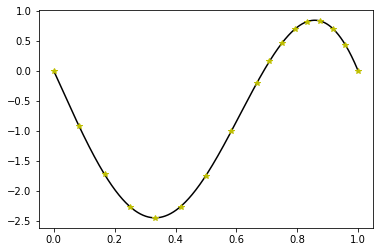

In [75]:
G = np.zeros([m,m])
F = np.zeros(m)

K = np.array([[1, -1],[-1, 1]])
P = np.array([[-1, 1],[-1, 1]])
Q = np.array([[2, 1],[1, 2]])

Fe = np.zeros(2)

#local_index = np.zeros(2)

ke = 1
pe = 0
qe = 1

for i in range(m-1):
    Ke = (ke / (pp[i+1] - pp[i])) * K
    Pe = (pe / 2) * P
    Qe = ((pp[i+1] - pp[i])*qe / 6) * Q
    Me = Ke + Pe +Qe
    
    Fe[0] = quad(lambda x,p: h(x)*(1 - (x - pp[i])/(pp[i+1] - pp[i])), pp[i], pp[i+1], args=(i,))[0]
    Fe[1] = quad(lambda x,p: h(x)*((x - pp[i])/(pp[i+1] - pp[i])), pp[i], pp[i+1], args=(i,))[0]
    
    #Mapping the local into the global matrix
    G[i:i+Me.shape[0],i:i+Me.shape[1]] += Me
    F[i:i+Fe.shape[0]] += Fe

    
# Boundary conditions (method 1)
#G[0,:] = 0.0
#G[m-1,:] = 0.0
#G[0,0] = 1.0
#G[m-1,m-1] = 1.0
#F[0] = 0.0
#F[m-1] = 0.0

# Boundary conditions method 2
G[0,0] = 10**10
G[-1,-1] = 10**10
F[0] = 0*10**10
F[-1] = 0*10**10

#Solving the linear system
sol_FEM = np.matmul(F, np.linalg.pinv(G))

plt.plot(x, ua(x), 'k', pp, sol_FEM, 'y*')

## Making $h(\zeta)$ also a linear combination of the bases (inside the element)

\begin{eqnarray}
h(\zeta) = h_1^e\phi_1+h_2^e\phi_2
\end{eqnarray} 



\begin{eqnarray}
\left[ \begin{array}{c}
IV^e \\
V^e \end{array} \right] = \frac{\Delta_x^e}{2}
\begin{bmatrix}
     (h_1^e + h_2^e)/2 \\
     (h_1^e + h_2^e)/2 \\
\end{bmatrix}
\end{eqnarray} 


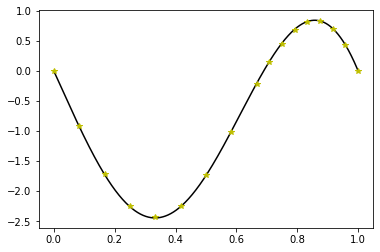

In [76]:
G = np.zeros([m,m])
F = np.zeros(m)

K = np.array([[1, -1],[-1, 1]])
P = np.array([[-1, 1],[-1, 1]])
Q = np.array([[2, 1],[1, 2]])

Fe = np.zeros(2)

#local_index = np.zeros(2)

ke = 1
pe = 0
qe = 1

for i in range(m-1):
    Ke = (ke / (pp[i+1] - pp[i])) * K
    Pe = (pe / 2) * P
    Qe = ((pp[i+1] - pp[i])*qe / 6) * Q
    Me = Ke + Pe +Qe
    
    #Fe[0] = quad(lambda x,p: h(x)*(1 - (x - pp[i])/(pp[i+1] - pp[i])), pp[i], pp[i+1], args=(i,))[0]
    #Fe[1] = quad(lambda x,p: h(x)*((x - pp[i])/(pp[i+1] - pp[i])), pp[i], pp[i+1], args=(i,))[0]
    
    Fe[0] = (pp[i+1] - pp[i]) * h((pp[i] + pp[i+1])/2) / 2
    Fe[1] = (pp[i+1] - pp[i]) * h((pp[i] + pp[i+1])/2) / 2
    
    #Mapping the local into the global matrix
    G[i:i+Me.shape[0],i:i+Me.shape[1]] += Me
    F[i:i+Fe.shape[0]] += Fe

# Boundary conditions method 2
G[0,0] = 10**10
G[-1,-1] = 10**10
F[0] = 0*10**10
F[-1] = 0*10**10

#Solving the linear system
sol_FEM = np.matmul(F, np.linalg.pinv(G))

plt.plot(x, ua(x), 'k', pp, sol_FEM, 'y*')

# Generalizing Finite Element Method for "any" equation

\begin{eqnarray}
-\frac{d}{dx}\left(k(x)\frac{du}{dx}\right)+p(x)\frac{du}{dx}+q(x)u=h(x), \nonumber
\end{eqnarray}

## $k(x)$, $q(x)$, $q(x)$, and $h(x)$ are constant inside each element.  

\begin{eqnarray}
K_e=\frac{k_e}{x^e_2-x^e_1}\left[ \begin{array}{cc}
1 & -1 \\
-1 & 1 \end{array} \right], \nonumber
\end{eqnarray}

\begin{eqnarray}
P_e=\frac{p_e}{2}\left[ \begin{array}{cc}
-1 & 1 \\
-1 & 1 \end{array} \right], \nonumber
\end{eqnarray}
## and,
\begin{eqnarray}
Q_e=\frac{q_e(x^e_2-x^e_1)}{6}\left[ \begin{array}{cc}
2 & 1 \\
1 & 2 \end{array} \right]. \nonumber
\end{eqnarray}
## where $M_e=K_e+P_e+Q_e$. That is because,
\begin{eqnarray}
\int_{x^e_1}^{x^e_2} [\phi_i'(x)\phi_i'(x)]dx&=&\frac{1}{x^e_2-x^e_1} \; \; \; \; (i=1,2), \nonumber \\
\int_{x^e_1}^{x^e_2} [\phi_i'(x)\phi_j'(x)]dx&=&-\frac{1}{x^e_2-x^e_1} \; \; \; \; (i=1,2 \; e \; j=1,2), \nonumber \\
\int_{x^e_1}^{x^e_2} [\phi_i(x)\phi_1'(x)]dx&=&-\frac{1}{2} \; \; \; \; \; \; (i=1,2), \nonumber \\
\int_{x^e_1}^{x^e_2} [\phi_i(x)\phi_2'(x)]dx&=&\frac{1}{2} \; \; \; \; \; \; (i=1,2), \nonumber \\
\int_{x^e_1}^{x^e_2} [\phi_i(x)\phi_i(x)]dx&=&\frac{x^e_2-x^e_1}{3} \; \; \; \; (i=1,2), \nonumber
\end{eqnarray}
## and, 
\begin{eqnarray}
\int_{x^e_1}^{x^e_2} [\phi_i(x)\phi_j(x)]dx&=&\frac{x^e_2-x^e_1}{6} \; \; (i=1,2\; e \; j=1,2). \nonumber
\end{eqnarray}

## finally
\begin{eqnarray}
F_e=\frac{h_e(x^e_2-x^e_1)}{2}\left[ \begin{array}{c}
1 \\
1 \end{array} \right], \nonumber
\end{eqnarray}
## because,
\begin{eqnarray}
\int_{x^e_1}^{x^e_2} [\phi_i(x)]dx=\frac{x^e_2-x^e_1}{2}\; \; (i=1,2). \nonumber
\end{eqnarray}

###############################################################################################################
# Heat flux

# Program for the numerical solution of the vertical one-dimensional general heat conduction equation

\begin{eqnarray}
C(\theta)\frac{\partial T}{\partial t} = \frac{ \partial}{\partial z}(\lambda(\theta)\frac{\partial T}{\partial z}) - C_w \frac{\partial(qT)}{\partial z}
\end{eqnarray}

## Discritizing the time,  $\frac{\partial T}{\partial t} \approx \frac{T - T_i}{\Delta t}$

\begin{eqnarray}
 -\frac{ \partial}{\partial z}(\lambda(\theta)\frac{\partial T}{\partial z}) + C_w \frac{\partial(qT)}{\partial z} + C(\theta)\frac{T}{\Delta t} = C(\theta)\frac{T_i}{\Delta t}
\end{eqnarray}

### SO,

## $k(x) = \lambda(\theta)$,  $p(x) = C_w q$, $q(x) = C(\theta)/\Delta t$, and $h(x) = C(\theta) T_i/\Delta t$

### inside each element these functions are constant, for example $\lambda(\theta) = \lambda_e$

In [77]:
Tavg = 30
Amp = 5
w = 0.6
dt = 3600
q = 0 #soil water flow equal zero

#soil water retention parameters in Van Genuchten-Mualem model
# LOAM SOIL
fwr = 0.078    #residual volumetric soil water content, m^3 m^-3
fws = 0.430    #saturated volumetric soil water content, m^3 m^-3
alpha = 3.6    #inverse of the bubbling pressure head, m^-1
n = 1.56       #pore-size distribution index
m = 1 - 1/n

num = 101
z = np.linspace(0,1,num)
pp = z # only to maintain the variable name


#initial soil temperature (Celsius)
#initial soil water pressure head (m)
#initial soil water content (m^3 m^-3)
T = np.zeros(len(z))
T += 20

h = -2 - z
fw = fwr + (fws - fwr) / (1 + (np.abs(alpha*h)**n)**m) #verify
fs = 1 - fws     #solid fraction
fa = fws - fw #air fraction


# volumetric heat capacity (J/m3.K)
# LOAM SOIL
Cs = 1.92e6    # solids
Cw = 4.18e6    # water
Ca = 0         # air

Ct = fs*Cs + fw*Cw + fa*Ca #soil


## Chung and Horton thermal conductivity (J/m.s.K)
## LOAM SOIL
b1 = 0.243
b2 = 0.393
b3 = 1.534

kn = b1 + b2*fw + b3*np.sqrt(fw)

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/

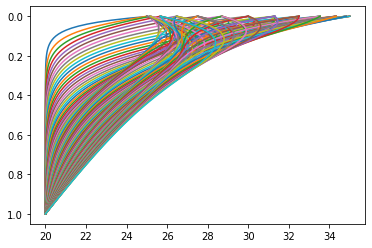

In [78]:

# initial time (s)
t = 0

m = len(pp)
G = np.zeros([m,m])
F = np.zeros(m)

K = np.array([[1, -1],[-1, 1]])
P = np.array([[-1, 1],[-1, 1]])
Q = np.array([[2, 1],[1, 2]])

Fe = np.zeros(2)

#local_index = np.zeros(2)

Big = 10**10
while (t < 5*86400):
    G = G*0
    F = F*0
    for i in range(len(z)-1):
                 
        # is the weightening factor needed????  
        ke = (kn[i] + kn[i+1]) / 2
        pe = Cw * q
        qe = ((Ct[i] + Ct[i+1])/2) / dt
        
        Ke = (ke / (pp[i+1] - pp[i])) * K
        Pe = (pe / 2) * P
        Qe = ((pp[i+1] - pp[i])*qe / 6) * Q
        Me = Ke + Pe + Qe
        
        
        f1 = ((Ct[i] + Ct[i+1])/2)*T[i]/dt
        f2 = ((Ct[i] + Ct[i+1])/2)*T[i+1]/dt
        
        Fe[0] = (pp[i+1] - pp[i])*( (f1 + f2)/2 ) / 2
        Fe[1] = (pp[i+1] - pp[i])*( (f1 + f2)/2 ) / 2
        
        
    #Mapping the local into the global matrix
        G[i:i+Me.shape[0],i:i+Me.shape[1]] += Me
        F[i:i+Fe.shape[0]] += Fe

# Boundary conditions (method 1)
#    G[0,:] = 0.0
#    G[m-1,:] = 0.0
#    G[0,0] = 1.0
#    G[m-1,m-1] = 1.0
#    F[0] = (Tavg + Amp * np.sin(2*np.pi*t/86400 - 7 * np.pi/12))
#    F[m-1] = 20.0        
        

# Boundary conditions method 2
    G[0,0] = Big
    G[-1,-1] = Big
    F[0] = (Tavg + Amp * np.sin(2*np.pi*t/86400 - 7 * np.pi/12))*Big
    F[-1] = 20*Big

#Solving the linear system    
    sol_FEM = ll.spsolve(G, F)
    
    #sol_FEM = np.matmul(F, np.linalg.pinv(G))
    
    #U, vm = A2U(G)
    #g = y2g(F, vm)
    #sol_FEM = sol_Gauss(U, g)
    
    T = sol_FEM
    t += dt
    plt.plot(sol_FEM, pp, '-')   
plt.gca().invert_yaxis()

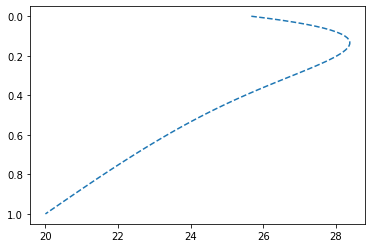

In [79]:
plt.plot(sol_FEM, pp, '--')
plt.gca().invert_yaxis()

In [80]:
t

432000

# Result from Finite Difference Method

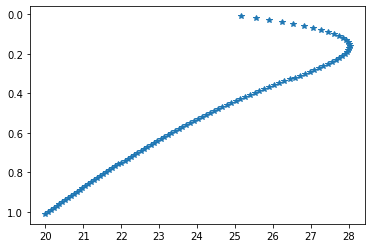

In [81]:
dd = np.loadtxt("../dd/1.out")
plt.plot(dd[:,1], dd[:,0]/100, '*')
plt.gca().invert_yaxis()

# Difference between the solution of both numerical methods

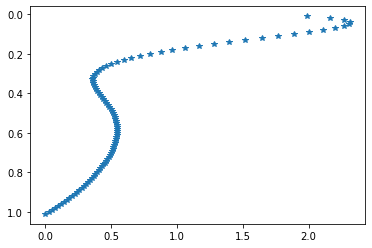

In [82]:
err = 100*abs(dd[:,1]-sol_FEM)/dd[:,1]
plt.plot(err, dd[:,0]/100, '*')
plt.gca().invert_yaxis()

# MT

\begin{eqnarray}
-\frac{d}{dz}\left(\frac{1}{i\omega \mu _0}\frac{dE_y}{dz}\right) + \frac{1}{\rho} E_y  &=&  0
\end{eqnarray}
### Then $k(x)=\frac{1}{i\omega \mu _0}$ \; $p(x)=0$ \; and $q(x)=\frac{1}{\rho}$. And $h(x) = 0$

### For the boundary conditions, usually it is assumed $E_t=1 \; V/m$ at the top and, $E_b=E_{y}(z) \approx 0$ at the bottom if z is deep enough ($5\times \delta$). 

### After obtaining the solution for each frequency,
\begin{eqnarray}
H_x=\frac{1}{i\omega \mu _0}\frac{dE_y}{dz}. \nonumber
\end{eqnarray}

\begin{eqnarray}
H_x=\frac{1}{i\omega \mu _0}\frac{E_y(z+\Delta z) - E_y(z-\Delta z)}{2\Delta z}. \nonumber
\end{eqnarray}

### and,
\begin{eqnarray}
\rho _a=\frac{1}{\omega \mu _0} \left\Vert \frac{E_y}{H_x} \right\Vert ^2, \nonumber \\
\nonumber \\
\phi=arcTg\left(\frac{Im(\frac{Ey}{Hx})}{Re(\frac{Ey}{Hx})}\right), \nonumber
\end{eqnarray}

# layered model


## $n$
## $\rho_i$ $\mu_{ri}$ $\Delta h_i$
## $\rho_n$ $\mu_{rn}$

In [83]:
with open('../mt/modelo1D_3cd.dat') as fg:
#with open('../mt/model.dat') as fg:
    n = int(fg.readline().strip())
    rho = np.zeros(n)
    mu = np.zeros(n)
    h = np.zeros(n-1)
    dump = fg.readlines()
    for i in range(n-1):
        rho[i], mu[i], h[i] = dump[i].split()
    rho[n-1], mu[n-1] = dump[n-1].split()

In [84]:
m0 = 4.*np.pi*10**-7
mu = mu*m0

In [85]:
hh = np.cumsum(h)

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


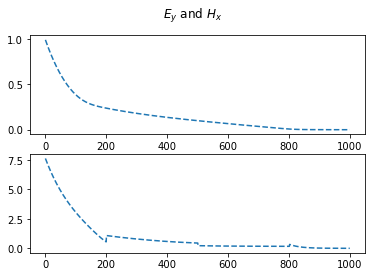

In [86]:
z = np.linspace(0, 1000, 1000) # discritazing the space

f = np.logspace(-5, 5, 50) # frequences that will be applied

m = len(z)

G = np.zeros([m, m], dtype=complex)
F = np.zeros(m, dtype=complex)


K = np.array([[ 1., -1.],[-1., 1.]], dtype=complex)
P = np.array([[-1.,  1.],[-1., 1.]], dtype=complex)
Q = np.array([[ 2.,  1.],[ 1., 2.]], dtype=complex)

Fe = np.zeros(2, dtype=complex)

Hx = np.zeros(m-2, dtype=complex)
rho_a = np.zeros(m-2)
rho_aS = []
phase = np.zeros(m-2)
phaseS = []

sk = np.sqrt ( 2. * max(rho) / (2.*np.pi*min(f)*m0))
z[-1] = 5.*sk
for ff in f:
        
    G = G*0.0
    F = F*0.0
    
    w = 2.0*np.pi*ff
    
# calculate the skin depth and replace the last node for it
    #sk = np.sqrt ( 2. * max(rho) / (w*m0))
#    if(5.*sk > z[-1]):
#        z[-1] = 5.*sk
#    else:
#        z[-1] = 1000
    
    pe = 0.0
    
    for i in range(len(z) - 1):
                     
        zz, ii = find_nearest(hh, z[i])
        
        if(zz >= z[i]):            
            ke = 1. / (1j*w*mu[ii])                       
            qe = 1. / rho[ii]    
        else:
            ke = 1. / (1j*w*mu[ii+1])
            qe = 1. / rho[ii+1]
            
        Ke = (ke / (z[i+1] - z[i]))       * K
        Pe = (pe / 2.0)                   * P
        Qe = ((z[i+1] - z[i]) * qe / 6.0) * Q
        
        Me = Ke + Pe + Qe
               
        Fe = Fe*0. 
                
    #Mapping the local into the global matrix
        G[i:i+Me.shape[0],i:i+Me.shape[1]] += Me
        F[i:i+Fe.shape[0]] += Fe

# Boundary conditions (method 1)
#    G[0,:] = 0.0 + 0*1j
#    G[m-1,:] = 0.0 + 0*1j
#    G[0,0] = 1.0 + 0*1j
#    G[m-1,m-1] = 1.0 + 0*1j
#    F[0] = 1 + 0*1j
#    F[m-1] = 0.0 + 0*1j        
        
    Big = 10.0**20
# Boundary conditions method 2
    G[0, 0] = Big
    G[-1, -1] = Big
    F[0] = 1.0*Big    
    F[-1] = 0.0*Big

#Solving the linear system
    Ey = ll.spsolve(G, F)

    #Ey = np.matmul(F, np.linalg.pinv(G))
    
    # Gauss method: comment the line above and uncomment the lines below 
    #UU, vvm = A2U(G)
    #gg = y2g(F, vvm)
    #Ey = sol_Gauss(UU, gg)

#Calculating H_x
    for i in range(m - 2):        
        zz, ii = find_nearest(hh, z[i])        
        if(zz >= z[i]):
            Hx[i]    = (1. / (1j*w*mu[ii])) *    (Ey[i+2] - Ey[i]) / (z[i+2] - z[i])
            rho_a[i] = (1. /    (w*mu[ii])) * abs(Ey[i+1]/Hx[i])**2
            
        else:
            Hx[i]    = (1. / (1j*w*mu[ii+1])) *    (Ey[i+2] - Ey[i]) / (z[i+1] - z[i])
            rho_a[i] = (1. /    (w*mu[ii+1])) * abs(Ey[i+1]/Hx[i])**2
            
        phase[i] = 180.0 + 180.0*np.arctan2(np.imag(Ey[i+1] / Hx[i]) ,  np.real(Ey[i+1] / Hx[i])) / np.pi

# Storing the apparent resistivity at the surface    
    rho_aS.append(rho_a[0])            
    phaseS.append(phase[0])
    fff, iii = find_nearest(f, 200) 
    if(fff == ff):
        fig, axs = plt.subplots(2)
        fig.suptitle('$E_y$ and $H_x$')
        axs[0].plot(z[1:m-1], abs(Ey[1:m-1]), '--')
        axs[1].plot(z[1:m-1], abs(Hx), '--')

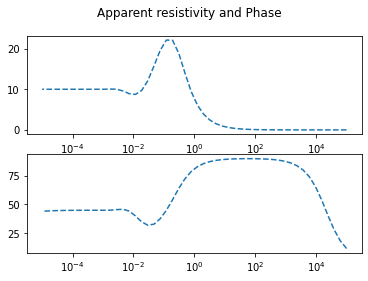

In [87]:
fig2, axs = plt.subplots(2)
fig2.suptitle('Apparent resistivity and Phase')
axs[0].semilogx(1/f,rho_aS,'--') 
axs[1].semilogx(1/f,phaseS,'--')

# MT 2D
$E = E^p + E^s$ and $\zeta = i\omega \mu$ and $\eta = \frac{1}{\rho}$ 

\begin{eqnarray}
\nabla\times\left(\frac{1}{\zeta}\nabla\times\vec{E^s} \right)+ \eta \vec{E^s}&=&-\left(\frac{\Delta \zeta}{\zeta}\eta ^p +\Delta \eta\right)\vec{E}^p -\frac{\Delta \zeta}{\zeta}\vec{J_t} , 
\end{eqnarray}

\begin{eqnarray}
-\frac{d}{dz}\left(\frac{1}{\zeta}\frac{dE_y^s}{dz}\right) + \eta E_y^s  &=& -(\frac{\Delta \zeta}{\zeta}\eta^p + \Delta\eta)E_y^p 
\end{eqnarray}
### Then $k(x)=1/\zeta$ \; $p(x)=0$ \; and $q(x)=\eta$. And $h(x) = -(\frac{\Delta \zeta}{\zeta}\eta^p + \Delta\eta)E_y^p$ 





In [88]:
n = 41
nx = 3*n - 2
nz = nx
nnos = nx*nz
nelem = 2*( nx -1) *( nz -1)


mu = 1.*m0
rhoS = 5.
rhoP = 100.

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


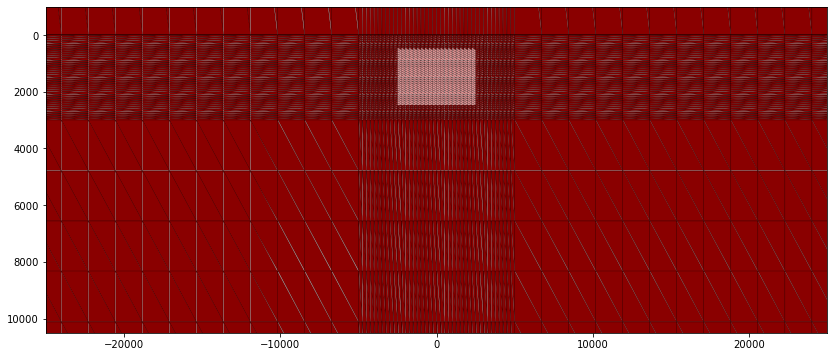

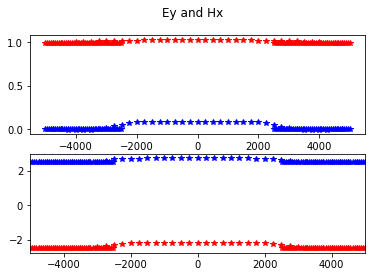

In [89]:
f = np.logspace(-4, 2, 50) # frequences that will be applied
x = np.zeros(3*n-2)
z = np.zeros(3*n-2)


rho = np.zeros(nelem) + rhoP

rho_a = np.zeros([nx,nz-2])
rho_aS = []
phase = np.zeros([nx,nz-2])
phaseS = []

lx = 5000
lz = 2000
ho = 500

border = []

################################# to plot the mesh
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches

mm = [0, 100]
# Define the colormap_
cmap = plt.cm.seismic
cmaplist2 = [cmap(i) for i in range(cmap.N)]

factor = 10 # increase this to drop the namber of colors
cmaplist = []
for i, c in enumerate(cmaplist2):
    if (i== 0 or i%factor == 0):
        cmaplist.append(cmaplist2[i]) 
cmapN = len(cmaplist)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmapN)
bounds = np.linspace(mm[0], mm[1], cmapN)
norm = mpl.colors.BoundaryNorm(bounds, cmapN)

fig_size = (14, 6)
fig, ax = plt.subplots(1, 1, figsize = fig_size)
##################################

for fff, ff in enumerate(f):
    
    sk = np.sqrt( 2. * rhoP / (2.*np.pi*ff*m0))
    #L = 5. * sk #+ 1000*lx
    L = 5. *500. * np.sqrt(10. * rhoP / ff ) / np.pi
    # MESH
    # define the coordenates and local index for each element
    ########################################################################

##### x
    dx = (L - lx) /  (n - 1) 
    x[0] = - L
    for i in range(1, n, 1):
        x[i] = x[i-1] +  dx
    
    dx = 2. * lx / (n - 1)
    for i in range(n, 2* n - 1, 1):
        x[i] = x[i-1] +  dx
    
    dx = (L - lx) / ( n - 1)
    for i in range(2*n -1,3* n-2,1):
        x[i] = x[i-1] +  dx
        
##### z
    dz = 4. * L / (n - 3)
    
    z[0] = - 4. * L
    for i in range(1, n-2, 1):
        z[i] = z[i-1] +  dz
    
    dz = 1.
    z[n-2] = dz
    z[n-1] = 2.*dz
    
    dz = (2.*ho + lz - z[n-1]) / (n - 1)
    for i in range(n, 2*n-1, 1):
        z[i] = z[i-1] +  dz
    
    dz = (L - z[2*n-2]) / ( n - 1)
    for i in range(2*n-1,3* n-2,1):
        z[i] = z[i-1] +  dz

# (x,z)
    coordenates = []
    for i in range(nx):
        for j in range(nz):
            coordenates.append([x[i], z[j]])
            if (j == 0 or i == 0 or j == nz-1 or i == nx-1):
                border.append(len(coordenates)-1)
    
    coordenates = np.asarray(coordenates)

# local index, to map later
    local_index = np.zeros([nelem, 3], dtype=int)
    
    local_index[0, 0] = 0
    local_index[0, 1] = nz
    local_index[0, 2] = nz + 1
    
    local_index[1, 0] = 0
    local_index[1, 1] = nz + 1
    local_index[1, 2] = 1 
    
    for i in range(2, 2*nz-2, 1):
        local_index[i,:] = local_index[i-2,:] + 1
        
    for i in range(2*nz - 2, nelem, 1):
        local_index[i,:] = local_index[i-(2*nz-2),:] + nz
        
    # fix the corner elements    
    local_index[2*nz - 3, 0] = nz - 2
    local_index[2*nz - 3, 1] = 2*nz - 2
    local_index[2*nz - 3, 2] = nz - 1
    
    local_index[2*nz - 4, 0] = 2*nz - 2
    local_index[2*nz - 4, 1] = 2*nz - 1
    local_index[2*nz - 4, 2] = nz - 1
    
    local_index[nelem - (2*nz - 2), 0] = nnos - (nz - 1)
    local_index[nelem - (2*nz - 2), 1] = nnos - (2*nz - 1)
    local_index[nelem - (2*nz - 2), 2] = nnos - (nz - 0)
    
    local_index[nelem - (2*nz - 3), 0] = nnos - (2*nz - 1)
    local_index[nelem - (2*nz - 3), 1] = nnos - (2*nz - 0)
    local_index[nelem - (2*nz - 3), 2] = nnos - (nz - 0) 

        
# FEM    
    #############################    
    m = len(coordenates)

    G = np.zeros([m, m], dtype=complex)
    F = np.zeros(m, dtype=complex)
    
    w = 2.0*np.pi*ff
    
    for i, index in enumerate(local_index):
           
        xe = coordenates[index,0]
        ze = coordenates[index,1]
        
        # Calculate the area of each triangle
        mat = np.zeros([3,3])
        mat[:,0] = 1.
        mat[:,1] = xe
        mat[:,2] = ze        
        A = abs(np.linalg.det(mat)) / 2.
        
        # Calculate the coeficients for the local "linear system"        
        b1 = ze[1] - ze[2]
        b2 = ze[2] - ze[0]
        b3 = ze[0] - ze[1]
        
        c1 = xe[2] - xe[1]
        c2 = xe[0] - xe[2]
        c3 = xe[1] - xe[0]
        
        indice = 25 # for ploting
        xm = xe.mean()
        zm = ze.mean()
        if( xm >= - lx /2 and xm <= lx /2):
            if ( zm >= ho and zm <=( ho + lz )):
                rho[i] = rhoS
                indice = 15 # fot ploting 
        
        zetha = 1j*w*mu
        zethaS = zetha
        zethaP = zetha
        detha = (1./rho[i] - 1./rhoP)
        
        ke = 1. / zetha
        pe = 0.0
        qe = 1. / rho[i]
        fe = - detha      
        
        Ke = ke * np.array([[(b1**2 + c1**2), (b1*b2 + c1*c2), (b1*b3 + c1*c3)],
                            [(b2*b1 + c2*c1), (b2**2 + c2**2), (b2*b3 + c2*c3)],
                            [(b3*b1 + c3*c1), (b3*b2 + c3*c2), (b3**2 + c3**2)]], dtype=complex) / (4.* A)
        
        Qe = qe * A * np.array([[2., 1., 1.],
                                [1., 2., 1.], 
                                [1., 1., 2.]], dtype=complex) / 12.
        
                
        # Calculating the primary field at the nodes
        kP = (1. - 1j)*np.sqrt(np.pi*ff*mu/rhoP)
        ey_p = 1.*np.exp(-1j*kP*ze)
    
        Fe = fe * A * np.array([2.*ey_p[0] +    ey_p[1] +    ey_p[2],
                                   ey_p[0] + 2.*ey_p[1] +    ey_p[2],
                                   ey_p[0] +    ey_p[1] + 2.*ey_p[2]]) / 12.                      
        
        Me = Ke + Qe
            
                
    #Mapping the local into the global matrix   
        for ii in range(3):
            for jj in range(3):
                G[index[ii], index[jj]] += Me[ii,jj]
            
            F[index[ii]] += Fe[ii]
      
        ################# ploting the element
        if (ff == f[int(len(f)/2)]):
            polygon = ((xe[0], ze[0]),
                       (xe[1], ze[1]),
                       (xe[2], ze[2]),
                       (xe[0], ze[0]))
            plotC = (cmaplist[indice])  
            codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]
            path = Path(polygon,codes)
            patch = patches.PathPatch(path, facecolor=plotC, edgecolor=None, lw=0.2)
            ax.add_patch(patch)
        ################
 
    Big = 10.0**30
    for b in border:
        G[b, b] = Big
        F[b] = 0.*Big
        
    #Solving the linear system
    Eys = ll.spsolve(G, F)
    Eys = Eys.reshape((nx,nz))
    
    Ey = Eys.copy()
    
#Calculating H_x     
    Hxp = Ey*0    
    for i in range(nx):
        for j in range(nz):
            Eyp = 1.*np.exp(-1j*kP*z[j])                
            Hxp[i,j] = -(1j * kP / zethaP ) * Eyp
            Ey[i,j] += Eyp
    
    Hx = Hxp*0
    
    for i in range(nx):
        for j in range(nz-2):
            Hx[i,j] = (1. / zetha) * (Eys[i,j+2] - Eys[i,j])/(z[j+2] - z[j]) + Hxp[i,j]
            
            rho_a[i,j] =  (1. / (w*mu)) * abs(Ey[i,j+1] / Hx[i,j])**2
            phase[i,j] = 180.0 + 180.0*np.arctan2(np.imag(Ey[i,j+1] / Hx[i,j]),
                                                  np.real(Ey[i,j+1] / Hx[i,j])) / np.pi
    
    mp = int(nx/2) + 1
    rho_aS.append(rho_a[mp, n-2])    


# Showing the mesh    
plt.xlim(-5*lx, 5*lx)
plt.ylim(-1000, ho + 5*lz)
    
plt.gca().invert_yaxis()
plt.show()
plt.close(fig)    

# Showing the Ey and Hx for the last frequency on the surface 
fig2, axs = plt.subplots(2)
plt.xlim((-5000, 5000))
fig2.suptitle('Ey and Hx')
axs[0].plot(x,np.real(Ey[:,n-2]),'*r') 
axs[1].plot(x,np.real(Hx[:,n-2]),'*r')
axs[0].plot(x,np.imag(Ey[:,n-2]),'*b') 
axs[1].plot(x,np.imag(Hx[:,n-2]),'*b')    

## $\rho_a$ at the center of the body

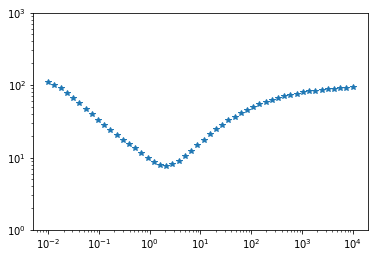

In [90]:
plt.loglog(1/f, rho_aS,'*')
plt.ylim((1, 1000))
plt.show()

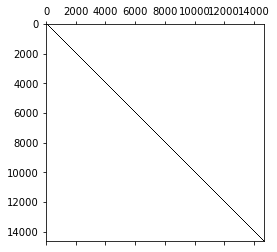

In [91]:
plt.spy(G)

# The same sulution (MT) with an unstructured mesh

In [92]:
import pygmsh
import numpy as np
import gmsh
import pygmsh
import sys
import meshio

def create_mesh(mesh, cell_type, prune_z=False):
        cells = mesh.get_cells_type(cell_type)
        cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
        out_mesh = meshio.Mesh(points=mesh.points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
        if prune_z:
            out_mesh.prune_z_0()
        return out_mesh

/opt/anaconda3/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in cdouble_scalars
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular

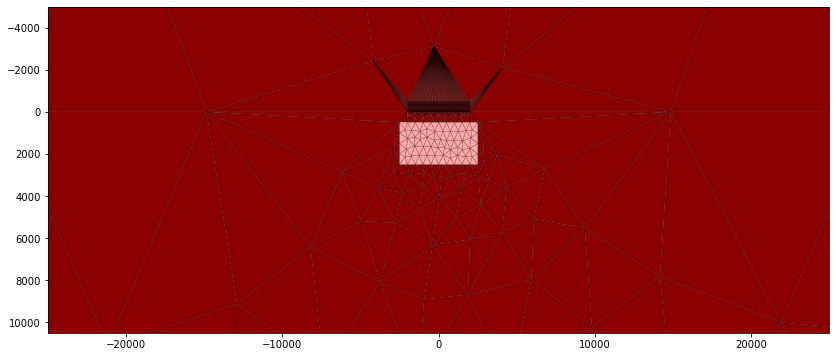

In [93]:
resolution = 500

f = np.logspace(-4, 2, 50) # frequences that will be applied

lx = 5000
lz = 2000
ho = 500

################################# to plot the mesh
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches

mm = [0, 100]
# Define the colormap_
cmap = plt.cm.seismic
cmaplist2 = [cmap(i) for i in range(cmap.N)]

factor = 10 # increase this to drop the namber of colors
cmaplist = []
for i, c in enumerate(cmaplist2):
    if (i== 0 or i%factor == 0):
        cmaplist.append(cmaplist2[i]) 
cmapN = len(cmaplist)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmapN)
bounds = np.linspace(mm[0], mm[1], cmapN)
norm = mpl.colors.BoundaryNorm(bounds, cmapN)

fig_size = (14, 6)
fig, ax = plt.subplots(1, 1, figsize = fig_size)
##################################

rho_aS = []
for fff, ff in enumerate(f):
    border = []
    
    sk = np.sqrt( 2. * rhoP / (2.*np.pi*ff*m0))
    L = 5. * sk + lx
    
    # MESH
    geometry = pygmsh.geo.Geometry()
    model = geometry.__enter__()

    # points of "measurements"
    n = 21
    x = np.linspace(-2000, 2000, n)
    s = []
    for i in range(n):
        s.append(model.add_point((x[i], 1, 0), mesh_size=resolution/10))
    for i in range(n):
        s.append(model.add_point((x[n-i-1], 2, 0),mesh_size=resolution/10))
        
    s_lines = [model.add_line(s[i], s[i+1])
                 for i in range(-1, len(s)-1)]
    s_loop = model.add_curve_loop(s_lines)
    ##########
    
    # I inclueded this retangle to have inprove the resolution only
    v = []
    
    for i in range(n):
        v.append(model.add_point((x[i], -1, 0), mesh_size=resolution/10))
    for i in range(n):
        v.append(model.add_point((x[n-i-1], -ho, 0),mesh_size=resolution/10))
           
    v_lines = [model.add_line(v[i], v[i+1])
                 for i in range(-1, len(v)-1)]
    v_loop = model.add_curve_loop(v_lines)
    ##########
    
# earth
    points = []
    points.append(model.add_point((-L, 0, 0),mesh_size=sk))
    for i in range(n):
        points.append(model.add_point((x[i], 0, 0),mesh_size=sk))
    points.append(model.add_point((L, 0, 0),mesh_size=sk))
    points.append(model.add_point((L, L, 0),mesh_size=sk))
    points.append(model.add_point((-L, L, 0),mesh_size=sk))

    channel_lines = [model.add_line(points[i], points[i+1])
                 for i in range(-1, len(points)-1)]

# air
    points2 = [model.add_point((-1.1*L, -4*L, 0),mesh_size=L),
          model.add_point((1.1*L, -4*L, 0),mesh_size=L),
          model.add_point((1.1*L, 1.1*L, 0),mesh_size=L),
          model.add_point((-1.1*L, 1.1*L, 0),mesh_size=L)]

    channel_lines2 = [model.add_line(points2[i], points2[i+1])
                 for i in range(-1, len(points2)-1)]

# body
    points3 = [model.add_point((-lx/2, ho, 0), mesh_size=resolution),
          model.add_point((lx/2, ho, 0), mesh_size=resolution),
          model.add_point((lx/2, ho+lz, 0), mesh_size=resolution),
          model.add_point((-lx/2, ho+lz, 0), mesh_size=resolution)]

    channel_lines3 = [model.add_line(points3[i], points3[i+1])
                 for i in range(-1, len(points3)-1)]

# Create a line loop and plane surface for meshing
    channel_loop = model.add_curve_loop(channel_lines)

    channel_loop2 = model.add_curve_loop(channel_lines2)

    channel_loop3 = model.add_curve_loop(channel_lines3)

    plane_surface = model.add_plane_surface(channel_loop,
                                        holes=[channel_loop3, s_loop])

    plane_surface2 = model.add_plane_surface(channel_loop2,
                                         holes=[channel_loop, v_loop])

    plane_surface3 = model.add_plane_surface(channel_loop3)
    
    s_surface = model.add_plane_surface(s_loop)
    
    v_surface = model.add_plane_surface(v_loop)

    model.synchronize()

    volume_marker = 6

    model.add_physical([plane_surface,s_surface], "earth")
    model.add_physical([plane_surface2, v_surface], "air")
    model.add_physical([plane_surface3], "body")
    
    # I am not using this yet later in the code
    model.add_physical([channel_lines[0],
                    channel_lines[2],
                    channel_lines[3],
                    channel_lines2[0],
                    channel_lines2[1],
                    channel_lines2[2]], "Walls")

    geometry.generate_mesh(dim=2)

    # Uncoment this to see the mesh at gmesh
    #if 'nopopup' not in sys.argv:
    #    gmsh.fltk.run()
    
    # convert the mesh to a convinient format
    gmsh.write("mesh.msh")
    gmsh.clear()
    geometry.__exit__()
    
    mesh_from_file = meshio.read("mesh.msh")

    triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
    meshio.write("mesh.vtk", triangle_mesh)
    mesh = meshio.read("mesh.vtk")
    ##########
    
    
    rho = mesh.cell_data['name_to_read'][0]
    coordenates = mesh.points[:,0:2]
    local_index = np.array(mesh.cells).all()
    
        
# FEM    
#############################    
    m = len(coordenates)

    G = np.zeros([m, m], dtype=complex)
    F = np.zeros(m, dtype=complex)
    
    w = 2.0*np.pi*ff
    
    
    for i, index in enumerate(local_index):        
        
        # find the nodes at the border
        for ee in range(3):
            if(coordenates[index[ee],0] == min(coordenates[:,0]) or 
               coordenates[index[ee],0] == max(coordenates[:,0]) or
               coordenates[index[ee],1] == min(coordenates[:,1]) or
               coordenates[index[ee],1] == max(coordenates[:,1])):
                if(index[ee] not in border):
                    border.append(index[ee])
                    
        xe = coordenates[index,0]
        ze = coordenates[index,1]
        
        indice = 25 # for ploting
        rho[i] = 100.0
        xm = xe.mean()
        zm = ze.mean()
        if( xm >= - lx /2 and xm <= lx /2):
            if ( zm >= ho and zm <=( ho + lz )):
                rho[i] = rhoS
                indice = 15
        
        # Calculate the area of each triangle
        mat = np.zeros([3,3])
        mat[:,0] = 1.
        mat[:,1] = xe
        mat[:,2] = ze        
        A = abs(np.linalg.det(mat)) / 2.
        
        # Calculate the coeficients for the local "linear system"        
        b1 = ze[1] - ze[2]
        b2 = ze[2] - ze[0]
        b3 = ze[0] - ze[1]
        
        c1 = xe[2] - xe[1]
        c2 = xe[0] - xe[2]
        c3 = xe[1] - xe[0]
          
        zetha = 1j*w*mu
        zethaS = zetha
        zethaP = zetha
        detha = (1./rho[i] - 1./rhoP)
        
        ke = 1. / zetha
        pe = 0.0
        qe = 1. / rho[i]
        fe = - detha      
        
        Ke = ke * np.array([[(b1**2 + c1**2), (b1*b2 + c1*c2), (b1*b3 + c1*c3)],
                            [(b2*b1 + c2*c1), (b2**2 + c2**2), (b2*b3 + c2*c3)],
                            [(b3*b1 + c3*c1), (b3*b2 + c3*c2), (b3**2 + c3**2)]], dtype=complex) / (4.* A)
        
        Qe = qe * A * np.array([[2., 1., 1.],
                                [1., 2., 1.], 
                                [1., 1., 2.]], dtype=complex) / 12.
                     
        # Calculating the primary field at the nodes
        kP = (1. - 1j)*np.sqrt(np.pi*ff*mu/rhoP)
        ey_p = 1.*np.exp(-1j*kP*ze)
    
        Fe = fe * A * np.array([2.*ey_p[0] +    ey_p[1] +    ey_p[2],
                                   ey_p[0] + 2.*ey_p[1] +    ey_p[2],
                                   ey_p[0] +    ey_p[1] + 2.*ey_p[2]]) / 12.                      
        
        Me = Ke + Qe
        
        ################# ploting the element
        if (ff == f[int(len(f)/2)]):
            polygon = ((xe[0], ze[0]),
                       (xe[1], ze[1]),
                       (xe[2], ze[2]),
                       (xe[0], ze[0]))
            plotC = (cmaplist[indice])  
            codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]
            path = Path(polygon,codes)
            patch = patches.PathPatch(path, facecolor=plotC, edgecolor=None, lw=0.2)
            ax.add_patch(patch)
        ################
            
                
        #Mapping the local into the global matrix   
        for ii in range(3):
            for jj in range(3):
                G[index[ii], index[jj]] += Me[ii,jj]           
            F[index[ii]] += Fe[ii]
        #########
    
    Big = 10.0**30
    for b in border:
        G[b, b] = Big
        F[b] = 0.*Big
        
    #Solving the linear system
    Eys = ll.spsolve(G, F)
##################    
    
    sz = np.array([coordenates[0,1], coordenates[n,1]])   
    Eyp = 1.*np.exp(-1j*kP*sz)
    Hxp = -(1j * kP / zethaP ) * Eyp
    
    
    for i in range(n):
        Ey[i] = ((Eys[i]+Eyp[0]) + (Eys[n+i]+Eyp[1])) / 2.
        Hx[i] = (1. / zetha) * (Eys[n+i] - Eys[i]) / (sz[1] - sz[0]) + np.mean(Hxp)
            
        rho_a =  (1. / (w*mu)) * abs(Ey / Hx)**2
        phase = 180.0 + 180.0*np.arctan2(np.imag(Ey/Hx),
                                          np.real(Ey/Hx))/ np.pi 
    rho_aS.append(rho_a[int(n/2)])    
                   
# Showing the mesh    
plt.xlim(-5*lx, 5*lx)
plt.ylim(-5000, ho + 5*lz)

plt.gca().invert_yaxis()
plt.show()
plt.close(fig)      
        

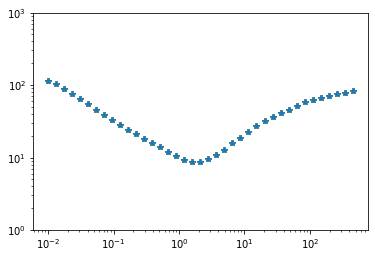

In [94]:
plt.loglog(1/f, rho_aS,'*')
plt.ylim((1, 1000))
plt.show()

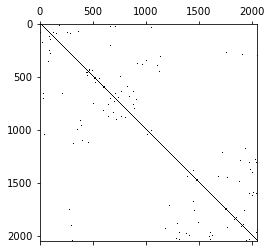

In [95]:
plt.spy(G)

# Heat flux 2D

In [124]:
import pygmsh
import numpy as np
import gmsh
import pygmsh
import sys
import meshio

def create_mesh(mesh, cell_type, prune_z=False):
        cells = mesh.get_cells_type(cell_type)
        cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
        out_mesh = meshio.Mesh(points=mesh.points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
        if prune_z:
            out_mesh.prune_z_0()
        return out_mesh

# MESH
geometry = pygmsh.geo.Geometry()
model = geometry.__enter__()

# points of "measurements"
nn = 100
z = np.linspace(0.01, 0.99, nn)
s = []
for i in range(nn):
    s.append(model.add_point((0, z[i], 0)))
for i in range(nn):
    s.append(model.add_point((0.01, z[nn-i-1], 0)))
        
s_lines = [model.add_line(s[i], s[i+1])
                 for i in range(-1, len(s)-1)]
s_loop = model.add_curve_loop(s_lines)
##########

# earth
points2 = [model.add_point((-0.5, 0, 0)),
          model.add_point((0.5, 0, 0)),
          model.add_point((0.5, 1, 0)),
          model.add_point((-0.5, 1, 0))]

channel_lines2 = [model.add_line(points2[i], points2[i+1])
                 for i in range(-1, len(points2)-1)]

channel_loop2 = model.add_curve_loop(channel_lines2)

plane_surface2 = model.add_plane_surface(channel_loop2,
                                        holes=[s_loop])

s_surface = model.add_plane_surface(s_loop)
    
model.synchronize()

#volume_marker = 6

model.add_physical([plane_surface2,s_surface], "earth")
    
geometry.generate_mesh(dim=2)

# Uncoment this to see the mesh at gmesh
if 'nopopup' not in sys.argv:
    gmsh.fltk.run()

    
# convert the mesh to a convinient format
gmsh.write("mesh.msh")
gmsh.clear()
geometry.__exit__()
    
mesh_from_file = meshio.read("mesh.msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh.vtk", triangle_mesh)
mesh = meshio.read("mesh.vtk")
    ##########
    
    
#T = mesh.cell_data['name_to_read'][0]*0 + 20.0

coordenates = mesh.points[:,0:2]
T = np.zeros(len(coordenates)) + 20.0
local_index = np.array(mesh.cells).all()

In [125]:
Tavg = 30
Amp = 5
dt = 3600
q = 0 #soil water flow equal zero

#soil water retention parameters in Van Genuchten-Mualem model
# LOAM SOIL
fwr = 0.078    #residual volumetric soil water content, m^3 m^-3
fws = 0.430    #saturated volumetric soil water content, m^3 m^-3
alpha = 3.6    #inverse of the bubbling pressure head, m^-1
n = 1.56       #pore-size distribution index
m = 1 - 1/n

# volumetric heat capacity (J/m3.K)
# LOAM SOIL
Cs = 1.92e6    # solids
Cw = 4.18e6    # water
Ca = 0         # air

## Chung and Horton thermal conductivity (J/m.s.K)
## LOAM SOIL
bb1 = 0.243
bb2 = 0.393
bb3 = 1.534

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaco

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaco

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaco

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaco

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaco

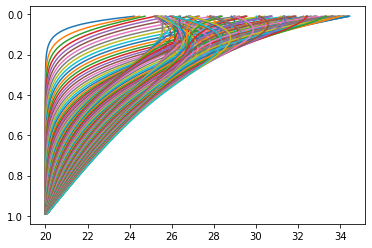

In [126]:
mm = len(coordenates)
t = 0
T = np.zeros(len(coordenates)) + 20.0
while (t < 5*86400):
    
    # FEM    
    #############################    
    G = np.zeros([mm, mm])
    F = np.zeros(mm)
    
    top = []
    bottom = []
    side = []
    for i, index in enumerate(local_index):        
        
        # find the nodes at the border
        for ee in range(3):
            
            if(coordenates[index[ee],1] == min(coordenates[:,1])):
                if(index[ee] not in top):
                    top.append(index[ee])
            
            if(coordenates[index[ee],1] == max(coordenates[:,1])):
                if(index[ee] not in bottom):
                    bottom.append(index[ee])
                    
            if(coordenates[index[ee],0] == min(coordenates[:,0]) or 
               coordenates[index[ee],0] == max(coordenates[:,0])):
                if(index[ee] not in side):
                    side.append(index[ee])
                    
        xe = coordenates[index,0]
        ze = coordenates[index,1]
        
        # Calculate the area of each triangle
        mat = np.zeros([3,3])
        mat[:,0] = 1.
        mat[:,1] = xe
        mat[:,2] = ze        
        A = abs(np.linalg.det(mat)) / 2.
        
        # Calculate the coeficients for the local "linear system"        
            
        b1 = ze[1] - ze[2]
        b2 = ze[2] - ze[0]
        b3 = ze[0] - ze[1]
        
        c1 = xe[2] - xe[1]
        c2 = xe[0] - xe[2]
        c3 = xe[1] - xe[0]
          
        h = -2.0 - ze
        fw = fwr + (fws - fwr) / (1 + (np.abs(alpha*h)**n)**m)
        fs = 1 - fws  #solid fraction
        fa = fws - fw #air fraction
        
        Ct = fs*Cs + fw*Cw + fa*Ca #soil
        
        kn = bb1 + bb2*fw + bb3*np.sqrt(fw)
        
        #???
        Cte = np.mean(Ct)
        kne = np.mean(kn)
        
        ke = kne
        pe = Cw * q
        qe = Cte / dt
        fe = Cte / dt 
        
        Ke = ke  * np.array([[(b1**2 + c1**2), (b1*b2 + c1*c2), (b1*b3 + c1*c3)],
                            [(b2*b1 + c2*c1), (b2**2 + c2**2), (b2*b3 + c2*c3)],
                            [(b3*b1 + c3*c1), (b3*b2 + c3*c2), (b3**2 + c3**2)]], dtype=complex) / (4.* A)
        
        Qe = qe * A * np.array([[2., 1., 1.],
                                [1., 2., 1.], 
                                [1., 1., 2.]], dtype=complex) / 12.
                     
        
        # I have to check it
        Pe = pe * A * np.array([[-1., 1., 1.],
                                [1., -1., 1.], 
                                [1., 1., -1.]], dtype=complex) / 12.
                      
    
        TT = T[index]
        Fe = fe * A * np.array([2.*TT[0] +    TT[1] +    TT[2],
                           TT[0] + 2.*TT[1] +    TT[2],
                           TT[0] +    TT[1] + 2.*TT[2]]) / 12.                      
        
        Me = Ke + Qe
          
                
        #Mapping the local into the global matrix   
        for ii in range(3):
            for jj in range(3):
                G[index[ii], index[jj]] += Me[ii,jj]           
            F[index[ii]] += Fe[ii]
        #########
    
    Big = 10.0**20
    for b in top:
        G[b, b] = Big
        F[b] = (Tavg + Amp * np.sin(2.*np.pi*t/86400 - 7.*np.pi/12))*Big

    
    for b in bottom:
        G[b, b] = Big
        F[b] = 20.*Big
        
    #for b in side:
    #    G[b, b] = Big
    #    F[b] = 20.*Big
        
    #Solving the linear system
    sol_FEM = ll.spsolve(G, F)
##################    
    T = sol_FEM
    t += dt
    plt.plot(sol_FEM[0:nn], z, '-')
plt.gca().invert_yaxis()

### taking advantage of the following equation,

\begin{eqnarray}
\int_{\Omega^e} \psi_1^\alpha\psi_2^\beta\psi_3^\gamma dxdz = 2\Delta^e \frac{\alpha !\beta ! \gamma !}{(\alpha + \beta + \gamma + 2)!}
\end{eqnarray}